# Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning

_By Phillip Hungerford,  University of New South Wales_

## PointNet Basic Model Testing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
cd drive

/content/drive


In [7]:
cd My Drive

/content/drive/My Drive


In [8]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [9]:
ls

 3D_medical_visualisation_script.py   original-voxel-model.ipynb
 data_prep.py                         plot.png
'EDA&PreProcessing.ipynb'             PointNetBasic.ipynb
 keras-test.ipynb                     PointNetFull.ipynb
 model_1024.h5                        __pycache__/
 my_model10204D.h5                    tf_util.py
 my_model1024xyzl.h5                  train.py
 my_model_16_16_16.h5                 voxel-model.ipynb
 my_model20454D.h5                    voxels.ipynb
 my_model4096.h5                      weights.h5


### 3.1. Install Dependencies

In [10]:
# For Google Colab
!pip install open3d-python

# for reading the ply files 
from open3d import *
import numpy as np

# for 3D visualisation
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# To time 
import time

# For reading the labels
import pandas as pd

    100% |████████████████████████████████| 3.3MB 8.9MB/s 


# PointNet Basic


## Model 1: Normal (n,1024,3) data

In [0]:
# Load 1024 data 
num_points=4096
X = np.load('../2_pipeline/prostate-no-nodes-' + str(num_points) + '.npy')
y = np.load('../2_pipeline/labels.npy')

from sklearn.model_selection import train_test_split

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

#from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

################################################################################
# Basic PointNet Keras
################################################################################
# Import dependencies
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten
################################################################################
# Set parameters 
max_epochs=200
batch_size=32

from keras.optimizers import SGD
opt = SGD(lr=0.0001, momentum=0.9)
#opt='adam'

# Class weights
class_weight = {0: 0.2,
                1: 0.8}
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(128, 1, activation='relu'))
model.add(Convolution1D(1024, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
################################################################################
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=0, validation_data=(X_val, y_val), class_weight=class_weight)
################################################################################

# Save model
#import pickle

# Save history
#with open('/trainHistoryDict', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

# Save model
#from keras.models import load_model
#model.save('my_model'+str(num_points)+'4D.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

################################################################################

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

################################################################################
# Classification Report
from sklearn.metrics import classification_report
# make predictions on the test set
y_pred = model.predict(X_test)
 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_true=y_test, y_pred=y_pred.round()))

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

################################################################################
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

################################################################################

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

################################################################################

Training shape is:  (182, 4096, 3)
Validation shape is:  (46, 4096, 3)
Test shape is:  (58, 4096, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 4096, 64)          256       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 4096, 64)          4160      
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 4096, 64)          4160      
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 4096, 128)         8320      
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 4096, 1024)        132096    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1, 1024)           0         
_________________________________________

## Model 2: Extra-column (n,1024,4) -> (x,y,z,l).

Training shape is:  (182, 1020, 4)
Validation shape is:  (46, 1020, 4)
Test shape is:  (58, 1020, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 1020, 64)          320       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1020, 64)          4160      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 1020, 64)          4160      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 1020, 128)         8320      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1020, 1020)        131580    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 1020)           0         
_________________________________________

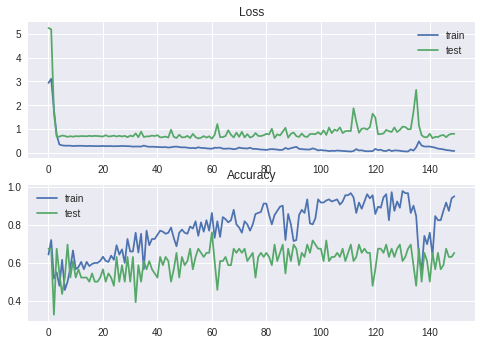

In [17]:
################################################################################
# Load 1024 data 
num_points=1020
X = np.load('../2_pipeline/1024-xyzl.npy')
y = np.load('../2_pipeline/labels.npy')

from sklearn.model_selection import train_test_split

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

#from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

################################################################################
# Basic PointNet Keras
################################################################################
# Import dependencies
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten
################################################################################
# Set parameters 
num_points=1020
max_epochs=200
batch_size=32

from keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)
#opt='adam'

# Class weights
class_weight = {0: 0.3,
                1: 0.7}
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 4), activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(128, 1, activation='relu'))
model.add(Convolution1D(1024, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

################################################################################
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=0, validation_data=(X_val, y_val), class_weight=class_weight)
################################################################################

# Save model
#import pickle

# Save history
#with open('/trainHistoryDict', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

# Save model
#from keras.models import load_model
#model.save('my_model'+str(num_points)+'4D.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

################################################################################

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

################################################################################
# Classification Report
from sklearn.metrics import classification_report
# make predictions on the test set
y_pred = model.predict(X_test)
 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_true=y_test, y_pred=y_pred.round()))

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

################################################################################
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

################################################################################

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

################################################################################

## Model 3: 4D (n,1024,3,2)

In [0]:
# Load pre-processed data
X = np.load('../2_pipeline/1020-4D.npy')
y = np.load('../2_pipeline/labels.npy')

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

#from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

print("Proportion of violations in split:")
print("Training set: ", sum(y_train))
print("Validation set: ", sum(y_val))
print("Test set: ", sum(y_test))

################################################################################
# Basic PointNet Keras with Conv2D
################################################################################

# Import dependencies
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Flatten
################################################################################

# Set parameters 
num_points=1020
max_epochs=150
batch_size=5

#from keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)
#opt='adam'

# Class weights
class_weight = {0: 0.3,
                1: 0.7}

################################################################################
### POINTNET ARCHITECTURE
################################################################################

# Point functions (MLP implemented as conv2d
model = Sequential()
model.add(Convolution2D(64, 1, input_shape=(num_points, 3, 3), activation='relu'))
model.add(Convolution2D(64, 1, activation='relu'))
model.add(Convolution2D(64, 1, activation='relu'))
model.add(Convolution2D(128, 1, activation='relu'))
model.add(Convolution2D(1024, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling2D(pool_size=(num_points,3), strides=None, padding='valid', data_format=None))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

# MLP on global point cloud vector
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
################################################################################

################################################################################
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=0, validation_data=(X_val, y_val), class_weight=class_weight)
################################################################################

# Save model
#import pickle

# Save history
#with open('/trainHistoryDict', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

# Save model
#from keras.models import load_model
#model.save('my_model'+str(num_points)+'4D.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

################################################################################

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

################################################################################
# Classification Report
from sklearn.metrics import classification_report
# make predictions on the test set
y_pred = model.predict(X_test)
 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_true=y_test, y_pred=y_pred.round()))

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

################################################################################
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

################################################################################

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

################################################################################

Training shape is:  (182, 1020, 3, 3)
Validation shape is:  (46, 1020, 3, 3)
Test shape is:  (58, 1020, 3, 3)
Proportion of violations in split:
Training set:  51.0
Validation set:  15.0
Test set:  22.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1020, 3, 64)       256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1020, 3, 64)       4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1020, 3, 64)       4160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1020, 3, 128)      8320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1020, 3, 1024)     132096    
_________________________________________________________________
max_p

KeyboardInterrupt: ignored

In [0]:
# Load model.
#model = load_model('my_model10204D.h5')

## 99. Cross Validation
Note using different activation and loss functions as opposed to previous models. 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy

# Load 1024 data 
X = np.load('../2_pipeline/1020-4D.npy')
y = np.load('../2_pipeline/labels.npy')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, y):
    ### POINTNET ARCHITECTURE
    
    # Point functions (MLP implemented as conv2d
    model = Sequential()
    model.add(Convolution2D(64, 1, input_shape=(num_points, 3, 3), activation='relu'))
    model.add(Convolution2D(64, 1, activation='relu'))
    model.add(Convolution2D(64, 1, activation='relu'))
    model.add(Convolution2D(128, 1, activation='relu'))
    model.add(Convolution2D(1024, 1, activation='relu'))

    # Symmetric function: max pooling
    model.add(MaxPooling2D(pool_size=(num_points,3), strides=None, padding='valid', data_format=None))

    #fully connected
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.add(Flatten())

    # Compile model
    # MLP on global point cloud vector
    model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

acc: 69.44%
acc: 69.44%
acc: 69.01%
acc: 30.99%
59.72% (+/- 16.59%)


The model with 1024 points scored:
* Test loss: 0.8002310043887089
* Test accuracy: 0.631578951132925

The model with body and 4096 points scored:
* Test loss:  1.2039089792653135
* Test accuracy:  0.6210526353434512

The model without the body with 4096 points scored:
* Test loss:  0.9736735845866956
* Test accuracy:  0.5894736785637705

The model without the body and 1024 points scored:
* Test loss: x
* Test accuracy: x

Model with 4096 points scored:
* Test loss of: 1.2039089792653135
* Test accuracy of: 0.6210526353434512